In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
plt.style.use('ggplot')

In [2]:
price_files = ['ADA-USD.csv', 'AGIX-USD.csv', 'BNB-USD.csv',
               'BTC-USD.csv', 'CAKE-USD.csv', 'DOGE-USD.csv',
               'DOT-USD.csv', 'ETH-USD.csv', 'FET-USD.csv',
               'FIL-USD.csv', 'KCS-USD.csv', 'LINK-USD.csv',
               'LTC-USD.csv', 'OCEAN-USD.csv', 'ROSE-USD.csv', 
               'SOL-USD.csv', 'UNI-USD.csv', 'XMR-USD.csv',
               'XRP-USD.csv', 'XTZ-USD.csv']

## TOKEN MAPPING
trend_to_token_mapping = {
    "bitcoin.csv": "btc",
    "bnb.csv": "bnb",
    "cardano.csv": "ada",
    "chainlink.csv": "link",
    "dogecoin.csv": "doge",
    "ethereum.csv": "eth",
    "fetch.ai.csv": "fet",
    "filecoin.csv": "fil",
    "kucoin.csv": "kcs",
    "litecoin.csv": "ltc",
    "monero.csv": "xmr",
    "oasis network.csv": "rose",
    "ocean protocol.csv": "ocean",
    "pancakeswap.csv": "cake",
    "polkadot.csv": "dot",
    "singularitynet.csv": "agix",
    "solana.csv": "sol",
    "tezos.csv": "xtz",
    "uniswap.csv": "uni",
    "XRP.csv": "xrp"
}


tokens = []

for pair in price_files:
    token = pair.split("-")[0].lower()
    tokens.append(token)


In [3]:
def get_trend(token, mapping):
    for k, v in mapping.items():
        if token == v:
            filename = f'trends/{k}'
            trends_df = pd.read_csv(filename)
            return trends_df
    return f'No Trend for token {token}'

def load_price_data(token, tokens_list, price_files):
    idx = tokens_list.index(token)
    filename = f'prices/{price_files[idx]}'
    return pd.read_csv(filename)
    

In [4]:
def clean_price_data(price_df):
    #Perform an initial check of df

    price_df['Date'] = pd.to_datetime(price_df['Date'])
    price_df['Year'] = pd.to_datetime(price_df['Date']).dt.year
    price_df['Month'] = pd.to_datetime(price_df['Date']).dt.month
    price_df['Day'] = pd.to_datetime(price_df['Date']).dt.day

    
    useful_columns = ['Date', 'Close', 'Volume', 'Year', 'Month', 'Day']
    price_df = price_df[useful_columns]
    return price_df

def clean_trend_data(trend_df):

    
    trend_df['Week'] = pd.to_datetime(trend_df['Week'])
    trend_df['Year'] = pd.to_datetime(trend_df['Week']).dt.year
    trend_df['Month'] = pd.to_datetime(trend_df['Week']).dt.month

    # Convert count to numeric to avoid non-correlation
    trend_df['count'] = pd.to_numeric(trend_df['count'], errors='coerce')
    trend_df['count'] = trend_df['count'].fillna(1)


    return trend_df

def merging_df(price_df, trend_df):
    #Resample data into Weekly data from daily
    weekly_price = price_df.set_index('Date')

    weekly_df = weekly_price.resample('W').agg({'Close': 'last', 'Volume': 'sum', 'Year': 'last', 'Month': 'last', 'Day': 'last'})
    weekly_df.reset_index(inplace=True)

    # Set the timeframe for merging
    week0 = trend_df['Week'][0]

    price_trend = weekly_df[weekly_df['Date']>=week0]
    price_trend.reset_index(inplace=True, drop=True)

    price_trend =  pd.merge(price_trend, trend_df, how='left', left_on='Date', right_on='Week')
    price_trend = price_trend[['Date', 'Close', 'Volume', 'Year_x', 'Month_x', 'count']]
    return price_trend


def correlations(df, token, ax=None):
    correlations = df.corr()
    if ax is None:
        fig, ax = plt.subplots(figsize=(10,10))         # Sample figsize in inches
    else:
        fig = ax.get_figure()
    sns.heatmap(correlations, annot=True, linewidths=.5, ax=ax, cmap="mako")
    ax.set_title(f'Correlations for {token}')
    fig.tight_layout()
    return ax

def plot_data(price_df, n_cols, token):

    fig, axes = plt.subplots(nrows=1, ncols=n_cols, figsize=(30, 8))
    fig.tight_layout(pad=5.0)

    axes[0].plot(price_df['Date'], price_df['Close'])
    axes[1].plot(price_df['Date'], np.log(price_df['Volume']))
    axes[0].set(xlabel='Date', ylabel='Price (USD)', title=f'{token}-USD Chart')
    axes[1].set(xlabel='Date', ylabel='log(Volume)', title=f'{token}-USD Volume')

    if n_cols == 3:
        axes[2].plot(price_df['Date'], price_df['count'])
        axes[2].set(xlabel='Date', ylabel='Word Count', title=f"{token}'s Google Trend")





In [5]:

btc_trend = get_trend('btc', trend_to_token_mapping)
btc_price = load_price_data('btc', tokens, price_files)
clean_btc = clean_price_data(btc_price)
clean_trend_btc = clean_trend_data(btc_trend)
btc_df = merging_df(clean_btc, clean_trend_btc)


In [34]:
# Function to segment data into cycles based on trend start points
def segment_cycles(df, start_points):
    cycles = []
    for i in range(len(start_points) - 1):
        start_date = start_points[i]
        end_date = start_points[i + 1]
        cycle_data = df[(df['Date'] >= start_date) & (df['Date'] < end_date)]
        cycles.append(cycle_data)
    return cycles

def plot_cycles(df, trend_start_points, ax=None):
    # Segment data into cycles
    cycles = segment_cycles(df, trend_start_points)

    if ax is None:
        # Create a new figure and axis if not provided
        fig, ax = plt.subplots(figsize=(10, 6))
    else:
        fig = ax.get_figure()

    # Plot cycles for each token
    for i, cycle_data in enumerate(cycles):
        ax.plot(cycle_data['Date'], cycle_data['count'], label=f'Cycle {i+1}')

    ax.set_xlabel('Date')
    ax.set_ylabel('Count')
    ax.set_title('Google Trends Over Time')
    ax.legend()

    return ax

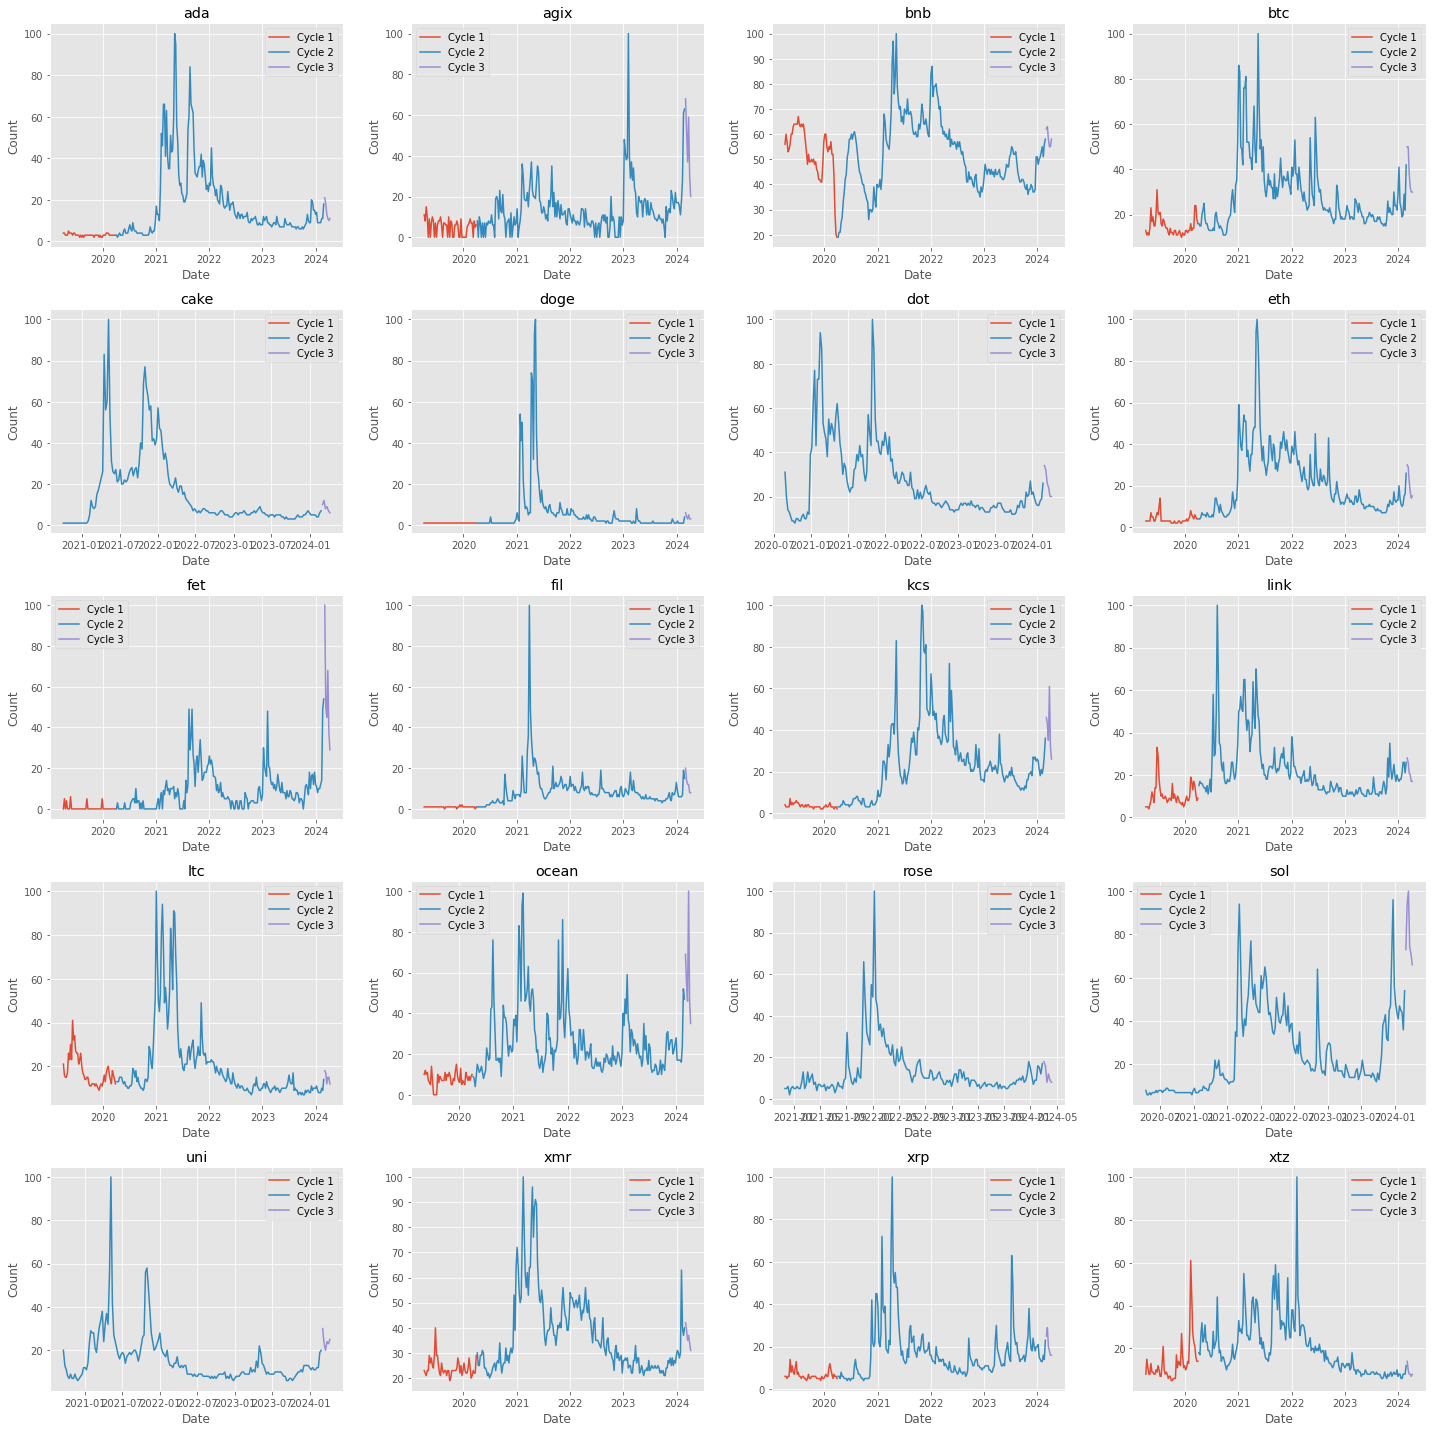

In [35]:
# Define the start points of trends
trend_start_points = ['2016-06', '2020-04', '2024-03', '2028-05']

# Convert start points to datetime format
trend_start_points = pd.to_datetime(trend_start_points)

# Sort the trend start points
trend_start_points = sorted(trend_start_points)

fig, axes = plt.subplots(5, 4, figsize=(20, 20))

for i, token in enumerate(tokens):
    trend_df = get_trend(token, trend_to_token_mapping)
    price_df = load_price_data(token, tokens, price_files)
    clean_price = clean_price_data(price_df)
    clean_trend = clean_trend_data(trend_df)
    price_trend_df = merging_df(clean_price, clean_trend)
    ax = axes[i // 4, i % 4]  # Get the appropriate subplot axes
    plot_cycles(price_trend_df, trend_start_points, ax=ax)
    ax.set_title(token)

# Adjust layout to prevent overlapping
plt.tight_layout()
plt.show()

In [38]:
from scipy.stats import ttest_ind
# Compute mean and standard deviation for each cycle
def compute_trend_statistics(df, start_points, token):
    cycles = segment_cycles(df, start_points)
    cycle_statistics = []
    cycle_count = 1
    print(f'***Statistical Comparision for different cycles on token {token}***\n')
    for cycle in cycles:
        cycle_mean = cycle['count'].mean()
        cycle_std = cycle['count'].std()
        cycle_statistics.append({'Mean': cycle_mean, 'Std': cycle_std})
        print(f'Cycle {cycle_count} has a mean {cycle_mean} and std {cycle_std}')
        cycle_count += 1

    # Perform hypothesis test (t-test) comparing means of consecutive cycles
    p_values = []
    for i in range(len(cycle_statistics) - 1):
        current_cycle = cycles[i]['count']
        next_cycle = cycles[i + 1]['count']
        t_stat, p_value = ttest_ind(current_cycle, next_cycle)
        p_values.append(p_value)

    # Output results
    for i, p_value in enumerate(p_values):
        cycle_num = i + 1
        if p_value < 0.05:
            print(f"There is a significant difference between cycle {cycle_num} and cycle {cycle_num + 1}. (p-value: {p_value})")
        else:
            print(f"There is no significant difference between cycle {cycle_num} and cycle {cycle_num + 1}. (p-value: {p_value})\n")

In [39]:
# Define the start points of trends
trend_start_points = ['2016-06', '2020-04', '2024-03', '2028-05']

# Convert start points to datetime format
trend_start_points = pd.to_datetime(trend_start_points)

# Sort the trend start points
trend_start_points = sorted(trend_start_points)

for token in tokens:
    trend_df = get_trend(token, trend_to_token_mapping)
    price_df = load_price_data(token, tokens, price_files)
    clean_price = clean_price_data(price_df)
    clean_trend = clean_trend_data(trend_df)
    price_trend_df = merging_df(clean_price, clean_trend)
    compute_trend_statistics(price_trend_df, trend_start_points, token)


***Statistical Comparision for different cycles on token ada***

Cycle 1 has a mean 3.0961538461538463 and std 0.6343010785267602
Cycle 2 has a mean 18.245098039215687 and std 17.623280770432434
Cycle 3 has a mean 14.0 and std 4.47213595499958
There is a significant difference between cycle 1 and cycle 2. (p-value: 2.4195145889418578e-09)
There is no significant difference between cycle 2 and cycle 3. (p-value: nan)

***Statistical Comparision for different cycles on token agix***

Cycle 1 has a mean 5.173076923076923 and std 3.988813543419007
Cycle 2 has a mean 13.764705882352942 and std 11.929742167747412
Cycle 3 has a mean 44.333333333333336 and std 18.359375443262408
There is a significant difference between cycle 1 and cycle 2. (p-value: 6.204580973229418e-07)
There is no significant difference between cycle 2 and cycle 3. (p-value: nan)

***Statistical Comparision for different cycles on token bnb***

Cycle 1 has a mean 52.78846153846154 and std 10.398598205794402
Cycle 2 has a m